# Model FMV Tone Stack
Example of using a LT Spice netlist of the FMV Tone Stack to retrieve the transfer function & frequency response.

07/08/2024
Guillermo A. R.
Eliot Deschang.

In [1]:
from scipy.signal import freqs, freqz # for retrieve analog freq. response
import numpy as np # the meaning of life
import sympy as sp # symbolic notation
import symbspice as symspi # magic library
import matplotlib.pyplot as plt # plotting

First, we need to declare a circuit object. We can either write a netlist by hand or just draw a circuit in LT Spice (following guidelines in README.md) and call the '.net' file.

In [2]:
circuit = symspi.Circuit(r'FMV Tone Stack.net')

We can get the symbolic continous transfer function between the output node and the input node. The input is set as the first node by default and the output as the last node (if a label was set).

In [3]:
H = circuit.tf(output_node = 6)
b, a = H.coeffs()
print(f'\nb coefficients :{b}')
print(f'a coefficients :{a}')


b coefficients :[C1*C2*C3*R1*Rb*Rm + C1*C2*C3*R1*Rb*Rt2 + C1*C2*C3*Rb*Rm*Rt1 + C1*C2*C3*Rb*Rm*Rt2, C1*C2*R1*Rb + C1*C2*R1*Rm + C1*C2*R1*Rt2 + C1*C2*Rb*Rt1 + C1*C2*Rb*Rt2 + C1*C2*Rm*Rt1 + C1*C2*Rm*Rt2 + C1*C3*R1*Rb + C1*C3*R1*Rm + C1*C3*R1*Rt2 + C1*C3*Rb*Rm + C1*C3*Rm*Rt1 + C1*C3*Rm*Rt2 + C2*C3*Rb*Rm, C1*Rb + C1*Rm + C1*Rt2 + C2*Rb + C2*Rm + C3*Rm, 0]
a coefficients :[C1*C2*C3*R1*Rb*Rm + C1*C2*C3*R1*Rb*Rt1 + C1*C2*C3*R1*Rb*Rt2 + C1*C2*C3*Rb*Rm*Rt1 + C1*C2*C3*Rb*Rm*Rt2, C1*C2*R1*Rb + C1*C2*R1*Rm + C1*C2*R1*Rt1 + C1*C2*R1*Rt2 + C1*C2*Rb*Rt1 + C1*C2*Rb*Rt2 + C1*C2*Rm*Rt1 + C1*C2*Rm*Rt2 + C1*C3*R1*Rb + C1*C3*R1*Rm + C1*C3*R1*Rt1 + C1*C3*R1*Rt2 + C1*C3*Rb*Rm + C1*C3*Rm*Rt1 + C1*C3*Rm*Rt2 + C2*C3*R1*Rb + C2*C3*Rb*Rm, C1*Rb + C1*Rm + C1*Rt1 + C1*Rt2 + C2*R1 + C2*Rb + C2*Rm + C3*R1 + C3*Rm, 1]


Now let's get the analog frequency response from our transfer function.

In [4]:
# Create freq axis
f = np.geomspace(1,20000, num=1000)
w = 2*np.pi*f
# Get numerical analog coefficients
b_num, a_num = H.num_coeffs()
print(f'\nb coefficients :{b_num}')
print(f'a coefficients :{a_num}')
# Get continuous frequency response
_, h = freqs(b_num, a_num, worN=w)


b coefficients :[1.9193625e-09 5.7651000e-06 1.1849625e-02 0.0000000e+00]
a coefficients :[3.3411125e-09 3.0223600e-05 1.6308375e-02 1.0000000e+00]


We can also discretize it with multiple schemes (Bilinear, Euler Forward & Euler Backward)

In [5]:
b_dig, a_dig = H.sym_coeffz('blnr', simple=True)
print(f'\nb coefficients :{b_dig}')
print(f'a coefficients :{a_dig}')


b coefficients :[T_s**3*b_0 + 2*T_s**2*b_1 + 4*T_s*b_2 + 8*b_3
 3*T_s**3*b_0 + 2*T_s**2*b_1 - 4*T_s*b_2 - 24*b_3
 3*T_s**3*b_0 - 2*T_s**2*b_1 - 4*T_s*b_2 + 24*b_3
 T_s**3*b_0 - 2*T_s**2*b_1 + 4*T_s*b_2 - 8*b_3]
a coefficients :[T_s**3*a_0 + 2*T_s**2*a_1 + 4*T_s*a_2 + 8*a_3
 3*T_s**3*a_0 + 2*T_s**2*a_1 - 4*T_s*a_2 - 24*a_3
 3*T_s**3*a_0 - 2*T_s**2*a_1 - 4*T_s*a_2 + 24*a_3
 T_s**3*a_0 - 2*T_s**2*a_1 + 4*T_s*a_2 - 8*a_3]


In [6]:
Fs = 48e3
b_dig, a_dig = H.num_coeffz(scheme='blnr', Fs=Fs)
# need to add normalize for discrete too
_, Hd = freqz(b_dig, a_dig, worN=f, fs=Fs)
print(f'\nb coefficients :{b_dig}')
print(f'a coefficients :{a_dig}')


b coefficients :[ 0.54151371 -1.5902986   1.55746216 -0.50867727]
a coefficients :[ 1.         -2.82591758  2.65377405 -0.82785399]


By exporting the results from LT Spice we can plot a comparison.

In [7]:
# Import LT Spice Results
data = open('FMV Tone Stack FR.txt','r')
lines = data.readlines()[1:]
data.close()
data = np.char.replace(lines, '\t', ',')
data = np.char.replace(data, '\n', '')
data = np.char.split(data, ',')

spiceF = np.zeros(len(data))
spiceH = np.zeros(len(data), dtype='complex')

for n, sample in enumerate(data):
    spiceF[n], spiceH[n]= float(sample[0]), float(sample[1]) + 1j * float(sample[2])

Plot results!

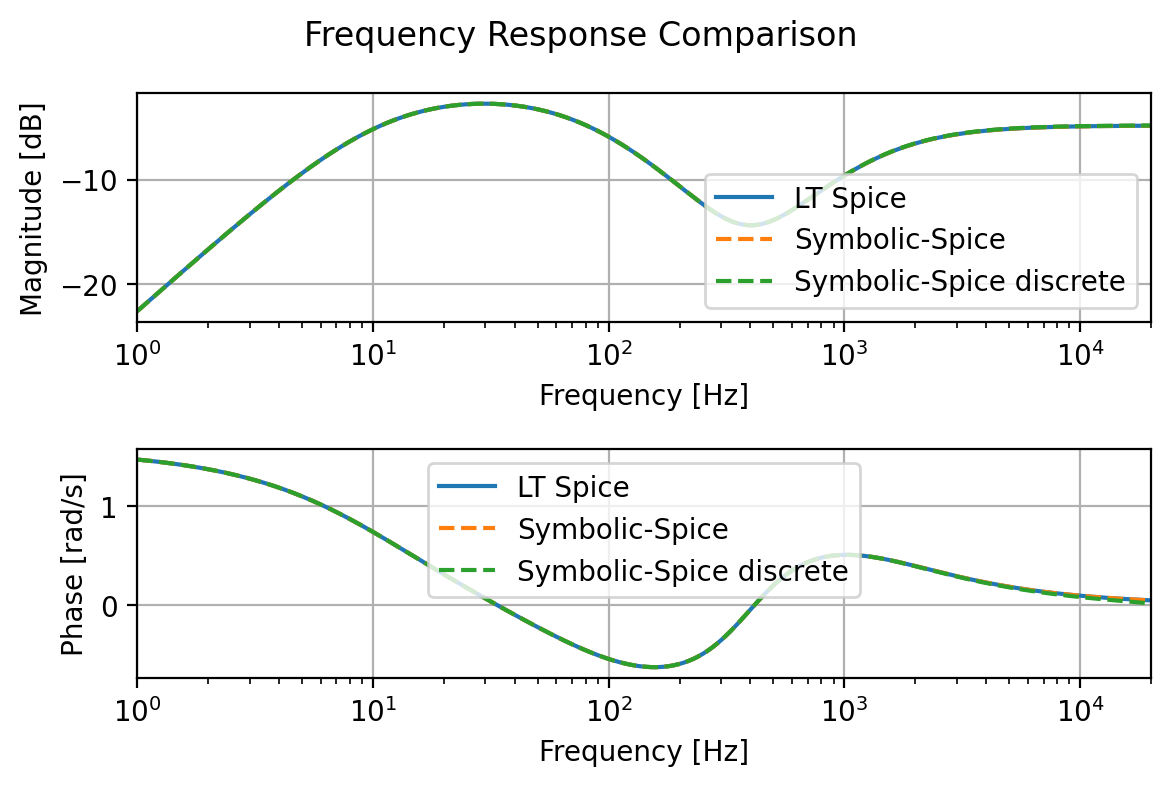

In [8]:
%matplotlib inline
plt.figure(figsize=(6,4))
plt.subplot(2,1,1)
plt.semilogx(spiceF, 20 * np.log10( np.abs(spiceH) ), label='LT Spice')
plt.semilogx(f, 20 * np.log10( np.abs(h) ), label='Symbolic-Spice', linestyle='--')
plt.semilogx(f, 20 * np.log10( np.abs(Hd) ), label='Symbolic-Spice discrete', linestyle='--')
plt.xlim((1,20e3))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.legend()
plt.subplot(2,1,2)
plt.semilogx(spiceF, np.angle(spiceH), label='LT Spice')
plt.semilogx(f, np.angle(h), label='Symbolic-Spice', linestyle='--')
plt.semilogx(f, np.angle(Hd), label='Symbolic-Spice discrete', linestyle='--')
plt.xlim((1,20e3))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [rad/s]')
plt.grid()
plt.legend()
plt.suptitle('Frequency Response Comparison')
plt.tight_layout()
plt.show()